# Data Science template - Titanic Case

Deze notebook begeleidt je stap voor stap door de **Titanic**-case op Kaggle.
De focus ligt op de standaard Data Science workflow:

1. Probleemdefinitie en doel
2. Data-input & Data cleaning
3. Verkenning (EDA)
4. Feature engineering
5. Modelleren (baseline → verbeterde modellen)
6. **Voorspelling** en export van `submission.csv`

> 🎯 Doel: voorspel de kans dat een passagier de Titanic-vaart heeft overleefd (`Survived`).

## 0. Doel & Omgevings-setup

- Download `train.csv` en `test.csv` handmatig van de Titanic-competitiepagina en plaats ze in een bijvoorbeeld in dezelfde map als dit bestand.


In [1]:
# !python --version


## 1. Imports

In [6]:
import pandas as pd
import numpy as np

# 1. CSV inlezen en "NaN" strings als echte NaN behandelen
train = pd.read_csv("train.csv", na_values=["NaN"])

# 2. Zorg dat Age numeriek is
train["Age"] = pd.to_numeric(train["Age"], errors="coerce")

# 3. Bereken gemiddelde en standaarddeviatie van bestaande leeftijden
mean_age = train["Age"].mean()
std_age = train["Age"].std()

# 4. Vul missende leeftijden in met normale verdeling en clamp tussen 0 en 81
train["Age"] = train["Age"].apply(
    lambda x: int(np.clip(np.random.normal(mean_age, std_age), 0, 81)) if pd.isna(x) else x
)

# 5. Controle: laat zien of er nog missende waarden zijn
print(train.isna().sum())

print(train['Age'])

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888    58.0
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64


## 2. Probleemdefinitie

- **Input**: passagiersgegevens zoals `Pclass`, `Sex`, `Age`, `SibSp`, `Parch`, `Fare`, `Embarked`, etc.
- **Output**: binaire target `Survived` (0 = niet overleefd, 1 = overleefd).
- **Metric (Kaggle leaderboard)**: **Accuracy** op de testset (zonder labels).


## 3. Data inladen

In [193]:
# Je gaat werken met de train data. In de test data staan de Survived kolom niet ingevuld. Deze moet je dus zelf voorspellen.

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.describe()

print(train.shape, test.shape)
train.head()

# hoeveel letters zinn er in embarked
#invullen...

# maak een dictionaries van Sex en Embarked
dict_Embarked = {'S':0, 'C':1, 'Q':2} 
dict_Sex = {"male": 0, "female": 1}
dict_Pclass = {1:0, 2:1, 3:2}

# drop missing values of column 'Embarked'
train = train.dropna(subset=['Embarked'])

# maak nieuwe kolommen voor sex en Embarked
train['Embarked_int'] = train['Embarked'].map(dict_Embarked)
train["Sex_int"] = train["Sex"].map(dict_Sex)
train['Pclass_0'] = train['Pclass'].map(dict_Pclass)

# print de dataset (nieuwe kolommen met integers komen erbij )
train.head()

# np.where(train.Embarked == 'S', train['Embarked_int']=1, train['Embarked_int']=0)

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_int,Sex_int,Pclass_0
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,2


## 4. Snelle datacheck & Preprocessing

Waar missen we (rijen met) data? Je kan missende data invullen door bijvoorbeeld voor bepaalde soort data op een bepaalde manier in te vullen:

- Numeriek: imputatie (median) + scaling
- Categorisch: imputatie (most_frequent) + one-hot encoding

In [139]:
#display(train.sample(5, random_state=42))
#display(train.describe(include='all'))
#train.isna().mean().sort_values(ascending=False)[:10]

train = train.dropna(subset=['Embarked'])
print(train.isna().sum())

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age             177
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          0
Embarked_int      0
Sex_int           0
dtype: int64


## 5. Verkennende Data Analyse (EDA)

> Tip: Voeg hier extra grafieken toe (bijv. histogrammen, boxplots, countplots per feature).


In [151]:
def make_survivle_table(col, bins):
    bins = pd.cut(train[col], bins=bins, right=False)
    counts = bins.value_counts().sort_index()
    probs  = train.groupby(bins)['Survived'].mean().reindex(counts.index)
    probs = probs.fillna(0.4)

    temp_df = pd.DataFrame({
      'bin': counts.index,
      'prob': probs.values,
      'count': counts.values
    }, index=[col]*len(counts))

    return temp_df

In [196]:
Survival_rates_lookup = pd.DataFrame(columns=['bin','prob','count'])
Age_bins_n = make_survivle_table('Age', range(0, 86, 5))
Fare_bins_n = make_survivle_table('Fare', range(0, int(train['Fare'].max()) + 5, 5))
Sex_bins_n = make_survivle_table('Sex_int', range(0, 3, 1))
SibSp_bins_n = make_survivle_table('SibSp', range(0, 7, 1))
Parch_bins_n = make_survivle_table('Parch', range(0, 8, 1))
Embarked_bins_n = make_survivle_table('Embarked_int', range(0, 4, 1))
Pclass_bins_n = make_survivle_table('Pclass_0', range(0, 4, 1))

Survival_rates_lookup = pd.concat([Survival_rates_lookup,
                                    Age_bins_n, 
                                    Fare_bins_n,
                                    Sex_bins_n,
                                    SibSp_bins_n,
                                    Parch_bins_n,
                                    Embarked_bins_n,
                                    Pclass_bins_n])

print(Survival_rates_lookup[Survival_rates_lookup.index == 'Pclass_0'])


C:\Users\guush\AppData\Local\Temp\ipykernel_16096\2349644298.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  probs  = train.groupby(bins)['Survived'].mean().reindex(counts.index)
C:\Users\guush\AppData\Local\Temp\ipykernel_16096\2349644298.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  probs  = train.groupby(bins)['Survived'].mean().reindex(counts.index)
C:\Users\guush\AppData\Local\Temp\ipykernel_16096\2349644298.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True t

             bin      prob count
Pclass_0  [0, 1)  0.626168   214
Pclass_0  [1, 2)  0.472826   184
Pclass_0  [2, 3)  0.242363   491


C:\Users\guush\AppData\Local\Temp\ipykernel_16096\714260856.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Survival_rates_lookup = pd.concat([Survival_rates_lookup,


C:\Users\guush\AppData\Local\Temp\ipykernel_16096\1758682035.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_bin = df.groupby("AgeBin")["SurvivalChance"].mean()


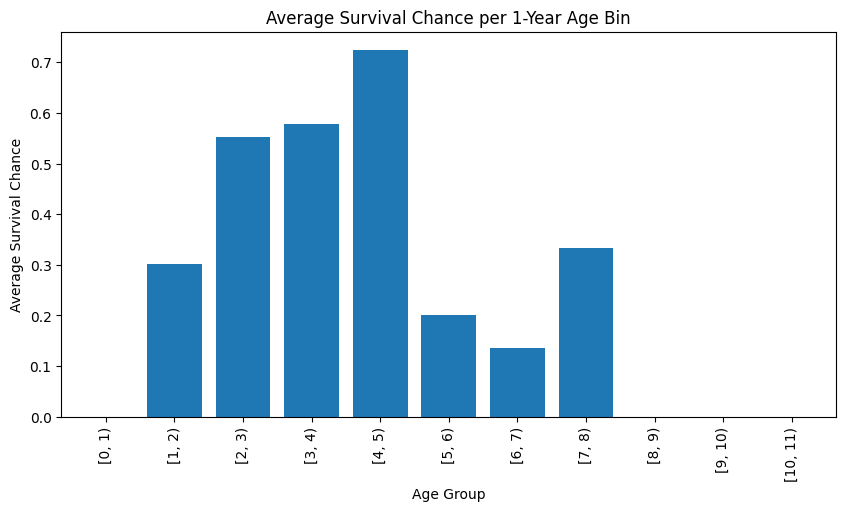

In [185]:
import matplotlib.pyplot as plt

# Convert Series to DataFrame
df = FS_n[1].reset_index()
df.columns = ["Age", "SurvivalChance"]

# Choose bin size (e.g., 10 years)
bin_size = 1
bins = range(0, int(df["Age"].max()) + bin_size, bin_size)

# Cut ages into bins and compute mean survival chance
df["AgeBin"] = pd.cut(df["Age"], bins=bins, right=False)
survival_by_bin = df.groupby("AgeBin")["SurvivalChance"].mean()

# Plot histogram (bar chart of averages per bin)
plt.figure(figsize=(10,5))
survival_by_bin.plot(kind="bar", width=0.8)
plt.xlabel("Age Group")
plt.ylabel("Average Survival Chance")
plt.title(f"Average Survival Chance per {bin_size}-Year Age Bin")
plt.show()


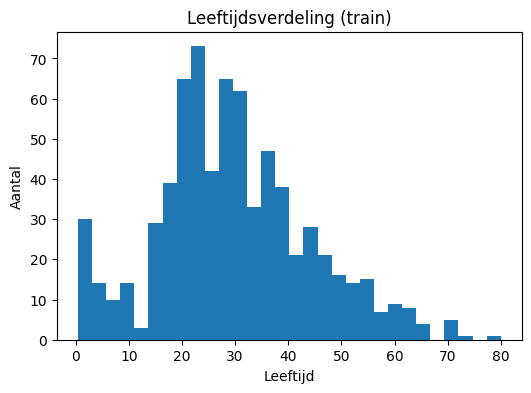

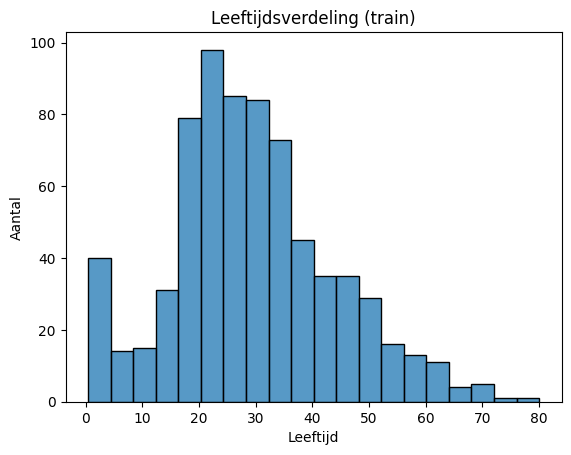

In [61]:
# Voorbeeld: verdeling leeftijd (met eenvoudige imputatie voor visualisatie)
# we verwijderen simpelweg alle rijen waar geen leeftijd bekend is.
ages = train['Age'].dropna()
plt.figure(figsize=(6,4))
plt.hist(ages, bins=30)
plt.title('Leeftijdsverdeling (train)')
plt.xlabel('Leeftijd'); plt.ylabel('Aantal')
plt.show()

sns.histplot(ages)
plt.title('Leeftijdsverdeling (train)')
plt.xlabel('Leeftijd'); plt.ylabel('Aantal')
plt.show()

In [ ]:
# Oefening: voeg je eigen EDA toe
# Gebruik Seaborn in plaats van Matplotlib.
# TODO: tel bijvoorbeeld overlevingspercentage per Pclass, Embarked, Fare-quantiles (pd.qcut), etc.

## 6. Feature Engineering

Voeg hier zelf extra features toe (bijv. `Title` uit `Name`, `FamilySize = SibSp + Parch + 1`, indicatoren, etc.).

Zorg wel dat het relevant is voor je eigen onderzoek. Waar ligt je eigen focus.

In [184]:
# Je kan nu zelf features aanmaken invullen. 
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

print(train['FamilySize'])
FS_n = pd.crosstab(train['FamilySize'], train['Survived'], normalize='index')


0      2
1      2
2      1
3      2
4      1
      ..
886    1
887    1
888    4
889    1
890    1
Name: FamilySize, Length: 889, dtype: int64


## 7. Baseline model — np.where invullen

In [ ]:
# === 3. Regelgebaseerde baseline met np.where ===
# Regel: vrouwen overleven altijd, jongens (<10 jaar) ook, anders niet
train_pred = np.where(
    (train['Sex'] == 'female') | ((train['Sex'] == 'male') & (train['Age'] < 10)),
    1, 0
)

## 8. Maak een eindmodel op volledige trainingsdata en voorspel op test

Hier kiezen we als voorbeeld het np.where model (of gebruik anders een ander model).


In [87]:
# === 4. Toepassen op testset ===
test_pred = np.where(
    (test['Sex'] == 'female') | ((test['Sex'] == 'male') & (test['Age'] < 10)),
    1, 0
)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_pred.astype(int)
})

submission.to_csv("submission.csv", index=False)
print("submission.csv aangemaakt!")
submission.head()

submission.csv aangemaakt!


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## 9. Checklist & Volgende stappen

- [ ] Zorg dat er een duidelijke samenhang is tussen de grafieken -> Feature Engineering -> je uiteindelijke model! Dat is het belangrijkst.
- [ ] Laat geen grafieken zien waar je niks mee doet tijdens de presentatie.
- [ ] Zorg dat er dus een rode draad is in je verhaal. 

Voorbeeld: We hebben de focus gelegd op leeftijd -> EDA laat deze grafieken met leeftijd zien. We hebben met Feature Engineering nog leeftijdsgroepen aangemaakt -> We hebben in het model de leeftijden gebruikt. Dit is onze score.

- [ ] Eventueel EDA (een klein beetje) uitbreiden (meer grafieken, correlaties, outliers)
- [ ] Feature engineering verbeteren (wat is er relevant?)
- [ ] Meer modellen proberen (Logistic Regression? Sklearn)
- [ ] Submission inleveren op kaggle en kijken hoe goed je score is

Succes met de case!